## Import

In [70]:
import pandas as pd
import numpy as np

import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from scipy.stats import mode
import statsmodels.api as sm


import seaborn as sns; 
sns.set_theme()

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

## Preprocessing

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [107]:

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

train_df.head()


Memory usage after optimization is: 259.40 MB
Decreased by 84.8%
Memory usage after optimization is: 63.90 MB
Decreased by 84.8%


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


In [108]:
train_df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,...,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.000000e+06,2.980192e+03,1.515857e+02,1.509754e+01,2.713154e+02,5.166262e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,...,3.746200e-02,3.782075e-02,1.199500e-02,1.605350e-02,1.071275e-02,1.220750e-02,4.075150e-02,3.923925e-02,3.161850e-02,1.771335e+00
std,1.154701e+06,2.890482e+02,1.099611e+02,8.546731e+00,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,...,1.898910e-01,1.907625e-01,1.088629e-01,1.256813e-01,1.029465e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01,8.938060e-01
min,0.000000e+00,1.773000e+03,-3.300000e+01,-3.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,9.999998e+05,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.000000e+06,2.966000e+03,1.230000e+02,1.400000e+01,2.130000e+02,3.100000e+01,1.436000e+03,2.180000e+02,2.240000e+02,1.420000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,2.999999e+06,3.217000e+03,2.470000e+02,2.000000e+01,3.610000e+02,7.800000e+01,2.365000e+03,2.330000e+02,2.370000e+02,1.690000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
max,3.999999e+06,4.383000e+03,4.070000e+02,6.400000e+01,1.602000e+03,6.470000e+02,7.666000e+03,3.010000e+02,2.790000e+02,2.720000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00


In [97]:
# train_df.drop(['Id'], axis=1)
# test_df.drop(['Id'], axis=1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2763,78,20,377,88,3104,218,213,195,1931,...,0,0,0,0,0,0,0,0,0,0
1,2826,153,11,264,39,295,219,238,148,2557,...,0,0,0,0,0,0,0,0,0,0
2,2948,57,19,56,44,852,202,217,163,1803,...,0,0,1,0,0,0,0,0,0,0
3,2926,119,6,158,134,2136,234,240,142,857,...,0,0,0,0,0,0,0,0,0,0
4,2690,10,4,38,108,3589,213,221,229,431,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2974,254,15,146,100,623,222,245,117,2353,...,0,0,0,0,0,0,0,0,0,0
999996,3180,92,16,93,47,3740,209,201,142,356,...,0,0,0,0,0,0,0,0,1,0
999997,2684,51,20,34,123,962,199,225,145,350,...,0,0,0,0,1,0,0,0,0,0
999998,3309,64,12,196,93,2522,226,193,74,3300,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
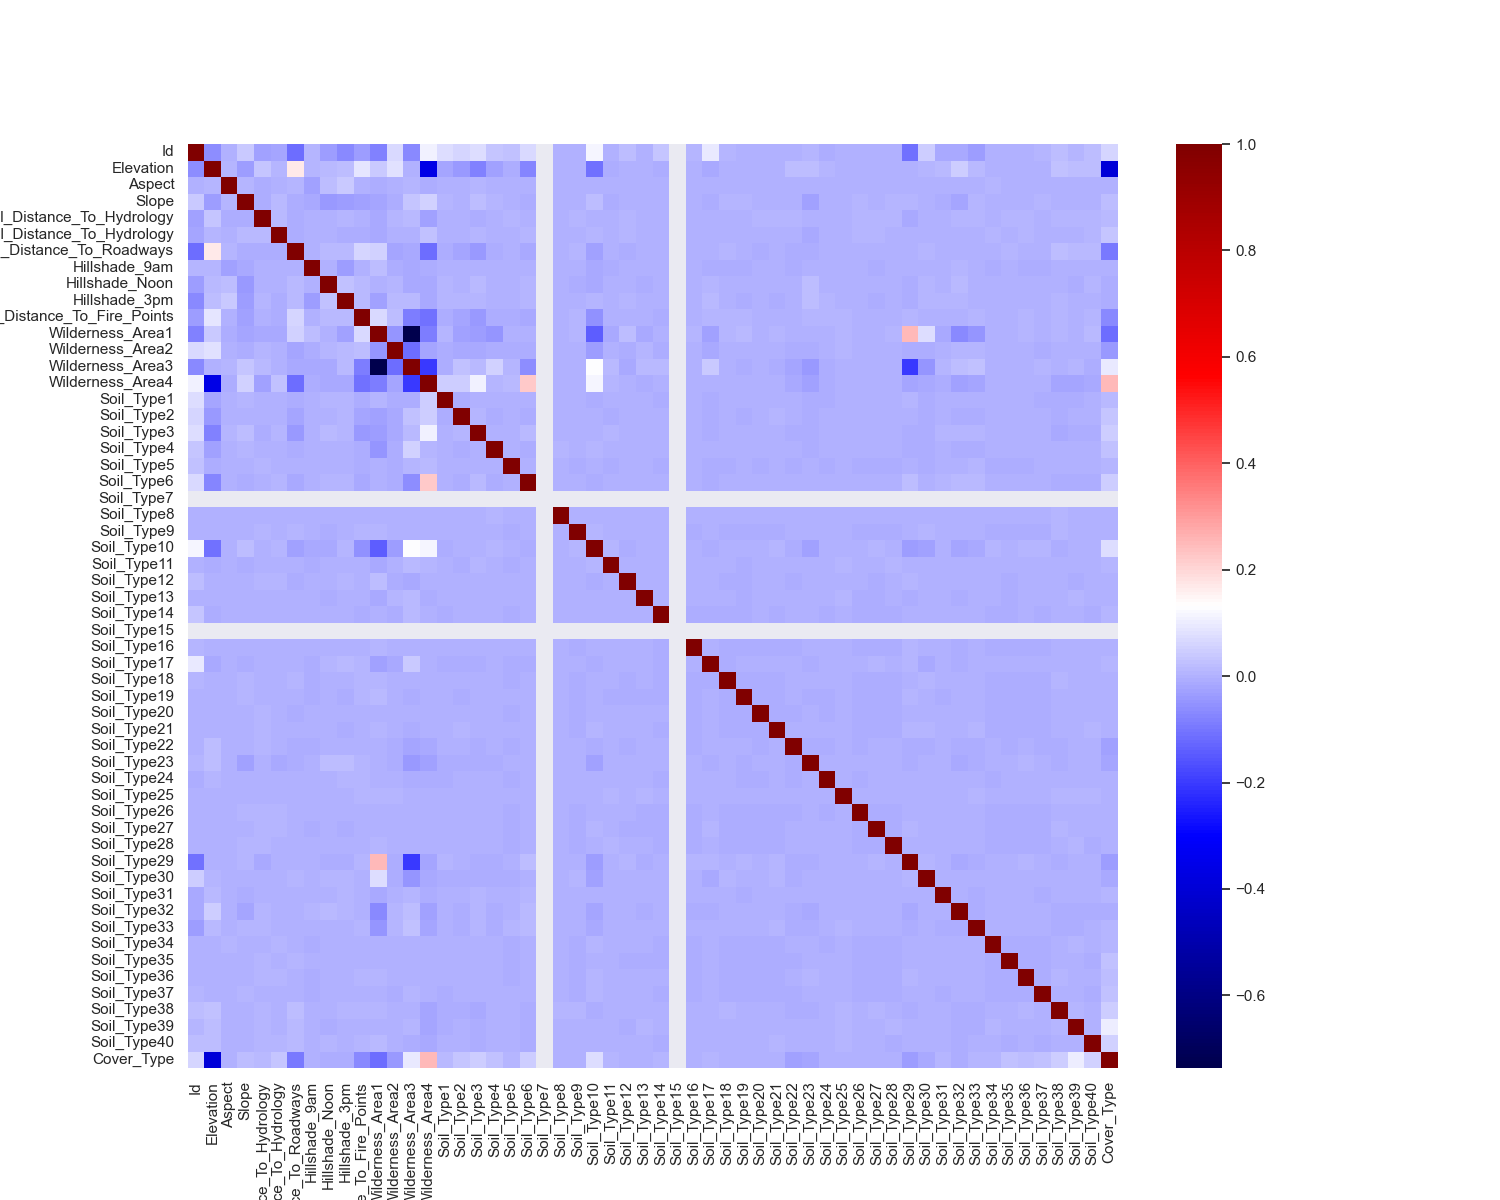

In [68]:
# scatter_matrix(train_df.iloc[:1000, :10])

fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train_df.iloc[:, :].corr(), cmap='seismic', annot=False, ax=ax)

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
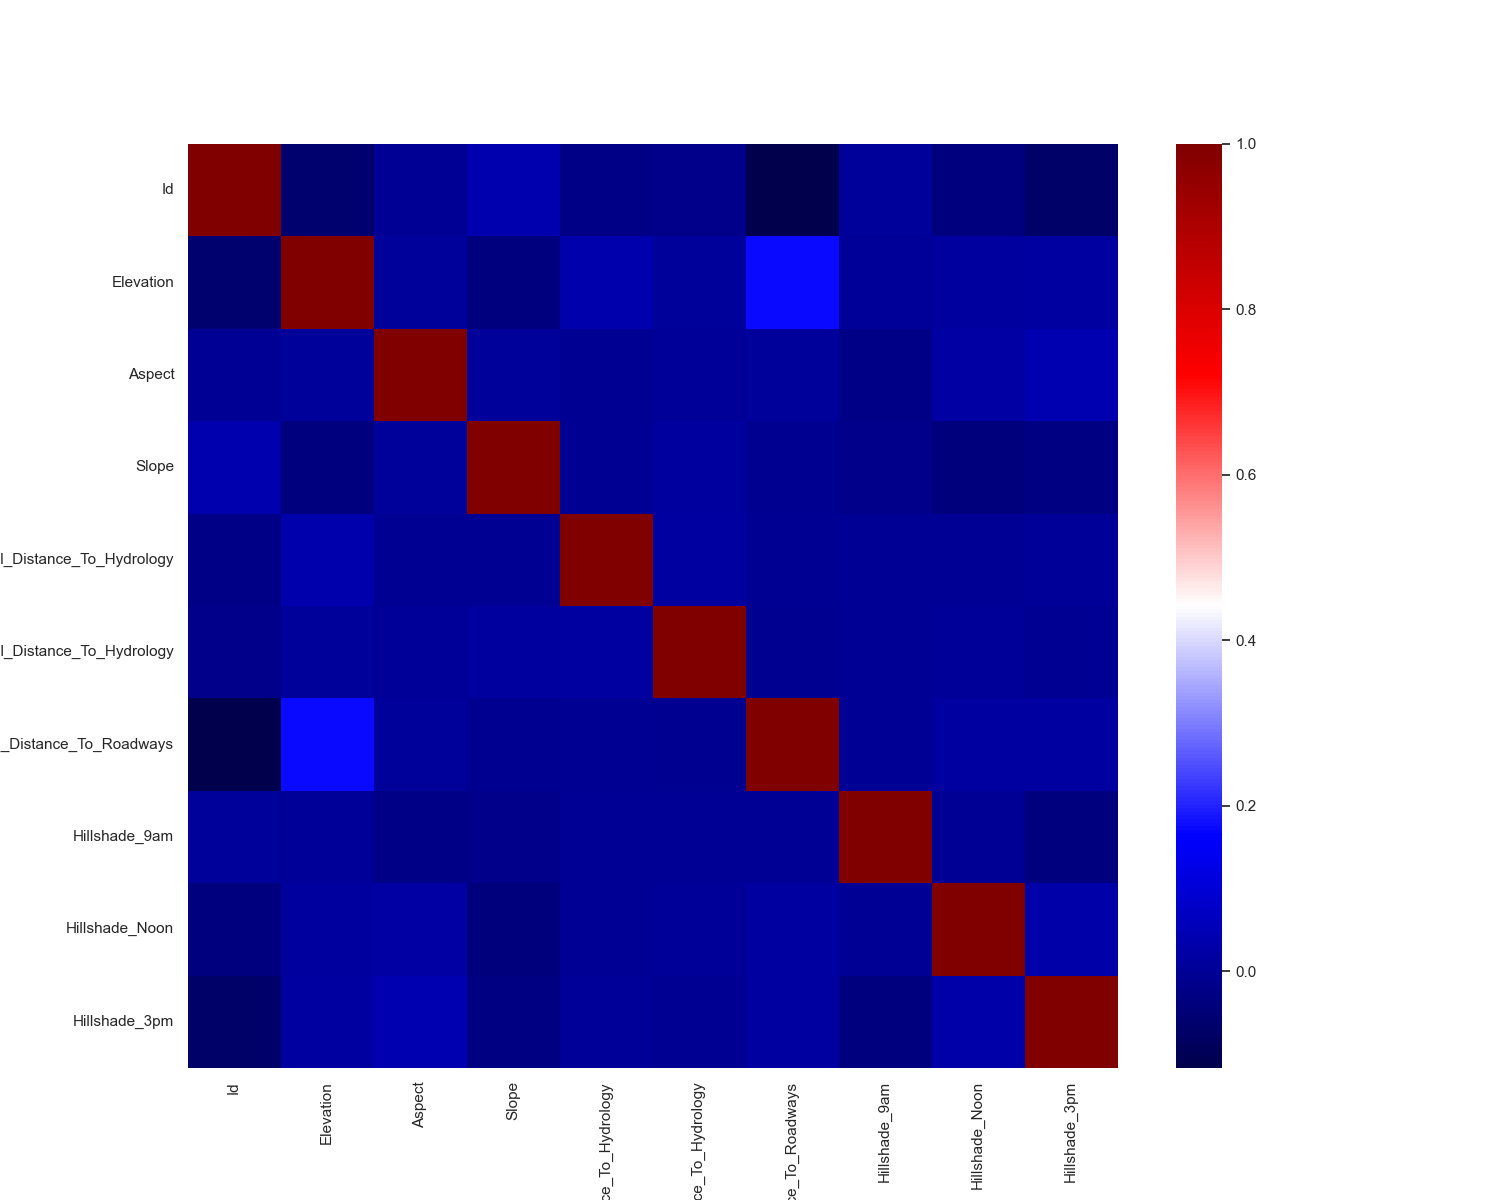

In [76]:

fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train_df.iloc[:, :10].corr(), cmap='seismic', annot=False, ax=ax)

In [72]:
X = train_df[["Wilderness_Area4", "Elevation" ]]
X = sm.add_constant(X)
y = train_df["Cover_Type"]

ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cover_Type   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                 4.097e+05
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:28:44   Log-Likelihood:            -4.8540e+06
No. Observations:             4000000   AIC:                         9.708e+06
Df Residuals:                 3999997   BIC:                         9.708e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.9919      0.005   1098.092      0.000       4.983       5.001
Wilderness_Area4     0.7550      0.003    252.519      0.000       0.749       0.761
Elevation           -0.0011   1.51e-06   -718.754      0.000      -0.001      -0.001
==============================================================================
Omnibus:                  4219414.192   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        232423933.805
Skew:                           5.511   Prob(JB):                         0.00
Kurtosis:                      38.680   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
print(train_df.iloc[:, :10].head())
print(train_df.columns[:10])
print(train_df.columns)

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       3189      40      8                                30   
1       3026     182      5                               280   
2       3106      13      7                               351   
3       3022     276     13                               192   
4       2906     186     13                               266   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              13                             3270   
1                              29                             3270   
2                              37                             2914   
3                              16                             3034   
4                              22                             2916   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  
0            206             234            193  
1            233             240            106  
2            208             234      

In [119]:
useful_features = [c for c in train_df.columns if c not in ("Id", "Cover_Type", "kfold")]

print(train_df.columns)
train_df = train_df.copy()[train_df.Cover_Type!=5]
# test_df = test_df[useful_features]

# useful_features = ['Id', 'Elevation', 'Aspect', 'Slope',
#        'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
#        'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
#        'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
#        'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
#        'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
#        'Soil_Type4', 'Soil_Type5', 'Soil_Type6']
xtrain_df = train_df[useful_features+['Cover_Type', 'Id']]
xtest_df = test_df.copy()[useful_features]

fold = 1
xtrain, xvalid = train_test_split(xtrain_df, test_size=0.2)

xtrain.reset_index(drop=True)
xvalid.reset_index(drop=True)

print(xvalid.columns)

valid_ids = xvalid.Id.values.tolist()

labels = preprocessing.LabelEncoder().fit(xtrain.Cover_Type)

ytrain = labels.transform(xtrain.Cover_Type)
yvalid = labels.transform(xvalid.Cover_Type)

true_valid = xvalid.Cover_Type

n_class = len(xtrain.Cover_Type.unique())

xtrain = xtrain[useful_features]
xvalid = xvalid[useful_features]


params = {
    'learning_rate': 0.02, 
    'reg_lambda': 17.1, 
    'reg_alpha': 1.2e-04, 
    'subsample': 0.25, 
    'colsample_bytree': 0.92, 
    'max_depth': 12,
    'grow_policy': 'depthwise'
}

model = XGBClassifier(
    
    random_state = 42,
    tree_method='gpu_hist',
    objective = 'multi:softmax',
    sampling_method = 'gradient_based',
    n_estimators=10000,
    n_jobs=-1,
    num_class = n_class,
    use_label_encoder=False,
    eval_metric = 'mlogloss',
    **params
)

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [120]:

model.fit(xtrain, ytrain,early_stopping_rounds=200, eval_set=[(xvalid, yvalid)], verbose=10)

[0]	validation_0-mlogloss:1.75271
[10]	validation_0-mlogloss:1.37798
[20]	validation_0-mlogloss:1.10130
[30]	validation_0-mlogloss:0.90025
[40]	validation_0-mlogloss:0.75283
[50]	validation_0-mlogloss:0.63629
[60]	validation_0-mlogloss:0.54248
[70]	validation_0-mlogloss:0.46759
[80]	validation_0-mlogloss:0.40611
[90]	validation_0-mlogloss:0.35586
[100]	validation_0-mlogloss:0.31570
[110]	validation_0-mlogloss:0.28232
[120]	validation_0-mlogloss:0.25558
[130]	validation_0-mlogloss:0.23246
[140]	validation_0-mlogloss:0.21368
[150]	validation_0-mlogloss:0.19695
[160]	validation_0-mlogloss:0.18301
[170]	validation_0-mlogloss:0.17171
[180]	validation_0-mlogloss:0.16189
[190]	validation_0-mlogloss:0.15350
[200]	validation_0-mlogloss:0.14648
[210]	validation_0-mlogloss:0.14019
[220]	validation_0-mlogloss:0.13499
[230]	validation_0-mlogloss:0.13062
[240]	validation_0-mlogloss:0.12638
[250]	validation_0-mlogloss:0.12262
[260]	validation_0-mlogloss:0.11940
[270]	validation_0-mlogloss:0.11653
[28

XGBoostError: bad allocation

In [121]:

# xtest = df_test.copy()

preds_valid = labels.inverse_transform(model.predict(xvalid))
test_preds = labels.inverse_transform(model.predict(xtest_df))

print(accuracy_score(true_valid, preds_valid))

NotFittedError: need to call fit or load_model beforehand

In [57]:

submission_df = pd.read_csv("data/sample_submission.csv")

test_ids = test_df.Id.values.tolist()
print(len(test_preds))
print(len(test_ids))
submission_df = pd.DataFrame(list(zip(test_ids, test_preds)), columns=["Id", "Cover_Type"])

# print(test_preds)
# submission_df.Cover_Type = mode(np.column_stack({}.update(dict(zip(valid_ids, preds_valid)))), axis=1)[0]
# print(np.column_stack(dict(zip(valid_ids, preds_valid)).items()))
#model(np.column_stack(final_test_predictions), axis=1)[0]
submission_df.columns = ["Id", "Cover_Type"]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

1000000
1000000


,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


In [ ]:
model.save_model("xgboost.json")